In [1]:
#%matplotlib inline
from matplotlib.pyplot import *
import numpy as np
import json
import datetime
import unicodedata
from pylab import rcParams
import os

In [2]:
rcParams['figure.figsize'] = 16,10
rcParams['font.size'] = 20

In [3]:
class Reaction:
    def __init__ (self, reaction_dict):
        self.actor=reaction_dict["actor"]
        self.reaction=reaction_dict["reaction"]

In [4]:
class Message:
    def __init__ (self, message_dict):
        if "content" in message_dict.keys():
            self.text=message_dict["content"]       #text of message
        else:
            self.text=""
        self.senderName=message_dict["sender_name"]      #sender's name
        self.time=datetime.datetime.fromtimestamp(message_dict["timestamp_ms"]//1000)      #time when message was sent
        self.reactions=[]
        if "reactions" in message_dict.keys():
            for reaction in message_dict["reactions"]:
                self.reactions.append(Reaction(reaction))

In [5]:
class Thread:
    def __init__ (self, allData):
        self.participants=[]
        self.messages=[]
        self.title=allData["title"]
        for participant in allData["participants"]:
            self.participants.append(participant)
        for message in allData["messages"]:
            self.messages.append(Message(message))
        self.messageCount=len(self.messages)
        self.messages=sorted(self.messages,key=lambda message: message.time)
    
    def messagesUntil (date):
        count=0
        for message in messages:
            if message.time<date:
                count+=1
        return count

In [19]:
threads=[]
base = os.path.join(os.getcwd(), "messages", "inbox")
dirs = next(os.walk(base))[1]
for s in dirs:
    dir=os.path.join(base, s)
    try:
        f = open(os.path.join(dir, "message_" + str(1) + ".json"), 'r', encoding='utf8')
        s = f.read().encode().decode('raw_unicode_escape').encode('latin1').decode('utf8')
        js = json.loads(s, strict=False)
        i = 2
        while True:
            try:
                f = open(os.path.join(dir, "message_" + str(i) + ".json"), 'r', encoding='utf8')
            except:
                break
            i += 1
            s = f.read().encode().decode('raw_unicode_escape').encode('latin1').decode('utf8')
            n = json.loads(s, strict=False)
            js["messages"].extend(n["messages"])
        threads.append(Thread(js))
    except:
        continue

In [23]:
threads=sorted(threads, key=lambda thread: thread.messageCount, reverse=True)

In [24]:
def printFirsts (n):
    ii=0
    for thread in threads:
        ii+=1
        print("%d. %s: %d messages" % (ii,thread.title,thread.messageCount))

In [33]:
def findExtremeDates(threadList):
    firstDate=threadList[0].messages[0].time
    lastDate=threadList[0].messages[-1].time
    for thread in threadList[1:]:
        if thread.messages[0].time<firstDate:
            firstDate=thread.messages[0].time
        if thread.messages[-1].time>lastDate:
            lastDate=thread.messages[-1].time
    return firstDate,lastDate

In [34]:
def messages_time (threadList):
    N = 1000
    firstDate, lastDate = findExtremeDates(threadList)
    totalDelta = lastDate - firstDate

    for thread in threadList:
        buckets = np.zeros(N)
        for m in thread.messages:
            buckets[int((m.time - firstDate) / totalDelta * (N - 1))] += 1
        buckets = np.cumsum(buckets)
        plot(buckets, label=thread.title)
        legend()
    
    xticks(fontsize=15, rotation = 90)
    xlabel("Date")
    ylabel("Number of messages (thousand)")
    title("Number of messages in time")
    grid(True)

C:\Users\bonif\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 127345 (\N{NEGATIVE SQUARED LATIN CAPITAL LETTER B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\bonif\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 129422 (\N{LIZARD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


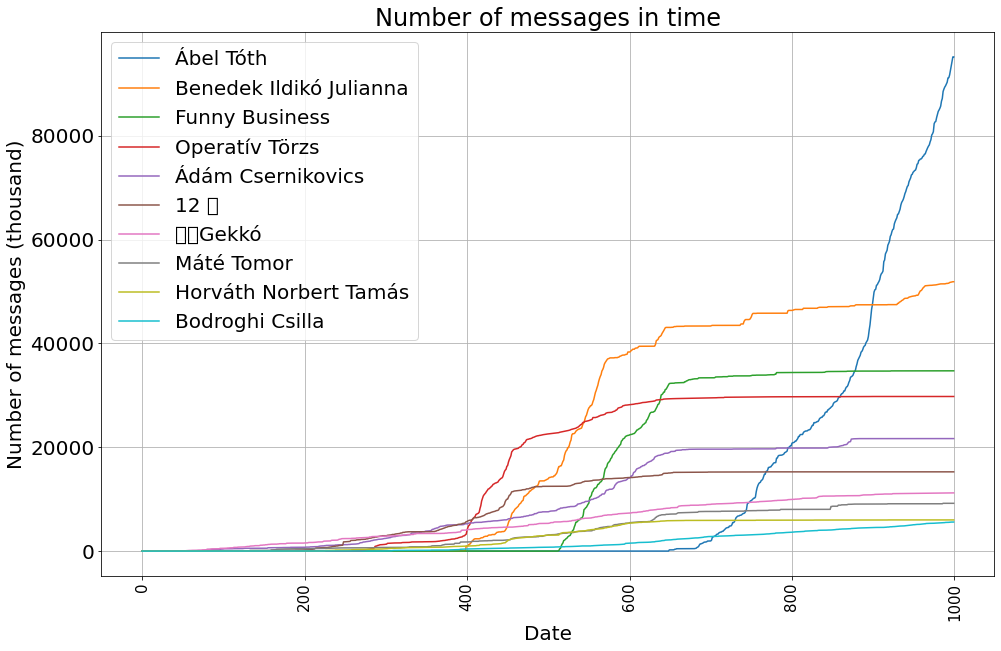

In [36]:
messages_time(threads[0:10])

In [74]:
def firstAndLastElements(listIn, topN, bottomN):
    if topN == None and bottomN==None:
        return listIn
    if topN == None:
        return listIn[-bottomN:]
    if bottomN == None:
        return listIn[:topN]
    if topN+bottomN>=len(listIn):
        return listIn
    return listIn[:topN]+ listIn[-bottomN:]

def senderStats (threadList, topN=None, bottomN=None):
    statsPerSender = {}

    for thread in threadList:
        for m in thread.messages:
                if m.text != "":
                    emojis = 0 #emoji.emoji_count(m['content'])
                    words = len(m.text.split())
                    letters = len(m.text) - emojis - words + 1
                if m.senderName in statsPerSender:
                    statsPerSender[m.senderName]['letter_count'] += letters
                    statsPerSender[m.senderName]['emoji_count'] += emojis
                    statsPerSender[m.senderName]['word_count'] += words
                    statsPerSender[m.senderName]['message_count'] += 1
                else:
                    statsPerSender[m.senderName] = {'letter_count': letters, 'emoji_count': emojis, 'word_count': words, 'message_count': 1}

    for s in statsPerSender:
        statsPerSender[s]['avg_word_len'] =    round(statsPerSender[s]['letter_count'] / statsPerSender[s]['word_count'], 1)
        statsPerSender[s]['avg_message_len'] = round(statsPerSender[s]['letter_count'] / statsPerSender[s]['message_count'], 1)

    print("Number of characters")
    for s in firstAndLastElements(sorted(statsPerSender.keys(), key=lambda x: statsPerSender[x]['letter_count'], reverse=True), topN, bottomN):
        print(s, ": ", statsPerSender[s]['letter_count'])

    #print("\nEmojik száma")
    #for s in firstAndLastElements(sorted(statsPerSender.keys(), key=lambda x: statsPerSender[x]['emoji_count'], reverse=True), topN, bottomN):
    #    print(s, ": ", statsPerSender[s]['emoji_count'])

    print("\nNumber of words")
    for s in firstAndLastElements(sorted(statsPerSender.keys(), key=lambda x: statsPerSender[x]['word_count'], reverse=True), topN, bottomN):
        print(s, ": ", statsPerSender[s]['word_count'])

    print("\nAverage length of words")
    for s in firstAndLastElements(sorted(statsPerSender.keys(), key=lambda x: statsPerSender[x]['avg_word_len'], reverse=True), topN, bottomN):
        print(s, ": ", statsPerSender[s]['avg_word_len'], " characters")

    print("\nÁtlagos üzenethossz karakterben")
    for s in firstAndLastElements(sorted(statsPerSender.keys(), key=lambda x: statsPerSender[x]['avg_message_len'], reverse=True), topN, bottomN):
        print(s, ": ", statsPerSender[s]['avg_message_len'])
    print("\n")

In [13]:
def messages_timeofday(messages):
    timestamps=getTime(messages)
    quarters = zeros(24 * 4)

    for t in timestamps:
        index = t.hour * 4 + t.minute // 15
        quarters[index] += 1

    kernel = array([0.09672046549155401, 0.24044903390287659, 0.3256610012111388, 0.24044903390287659, 0.09672046549155401])
    r = kernel.size // 2
    smoothed = zeros(24 * 4)
    for i in range(24 * 4):
        s = 0
        for j in range(-r, r + 1):
            s += kernel[j + r] * quarters[(i + j) % (24 * 4)]
        smoothed[i] = s / 15
            
    x = [i / 4 for i in range(24 * 4)]
    plot(x, smoothed,"r")

    xlabel("Napon belüli órák")
    ylabel("Üzenetek száma ebben a percebn")
    title("Az üzenetek relatív gyakorisága a napon belül")
    xticks([0,4,8,12,16,20,24])

    xlim(0, 24.00)
    grid(True)
    show()

In [14]:
def standardizeTexts(threadList):
    flatMess = []
    for thread in threadList:
        for m in thread.messages.copy():
            if m.text != "":
                m2 = m.copy()
                s = m.text
                m2.text = unicodedata.normalize('NFD', s).encode('ascii', 'ignore').lower().decode("utf-8") 
                flatMess.append(m2)
    return flatMess

In [80]:
def searchCount(threadList, key):
    key = unicodedata.normalize('NFD', key).encode('ascii', 'ignore').lower().decode("utf-8") 
    result = dict()
    for thread in threadList:
        for m in thread.messages:
            c = m.text.count(key)
            if (m.senderName in result):
                result[m.senderName]['count'] += c
            else:
                result[m.senderName] = {'count': c}

    return result

In [16]:
def WordNumber (threadList, key):
    flatMess = standardizeTexts(threadList)
    hits += searchCount(flatMess, key)

    print("Találatok száma a(z) \"" + str(key) + "\" kifejezésre")
    for s in sorted(hits.keys(), key=lambda x: hits[x]['count'], reverse=True):
        print(s, ": ", hits[s]['count'])
    print("\n")

In [17]:
def getWordCounts(messsages):
    wordCounts = dict()
    flatMess=getFlatMess(messages)
    for m in flatMess:
            words = m['content'].split()
            for word in words:
                if (m['sender_name'] in wordCounts):
                    if (word in wordCounts[m['sender_name']]):
                        wordCounts[m['sender_name']][word] += 1
                    else:
                        wordCounts[m['sender_name']][word] = 1
                else:
                    wordCounts[m['sender_name']] = {word: 1}
    return wordCounts

In [18]:
def mostUsedWords(messages):
    wordCounts=getWordCounts(messages)
    print("Legtöbbször használt szavak:")
    for s in wordCounts.keys():
        print(s)
        for w in sorted(wordCounts[s], key=wordCounts[s].get, reverse=True)[0:11]:
            print(w, ":", wordCounts[s][w])
        print()
        #print(sorted(wordCounts[s], key=wordCounts[s].get, reverse=True))

    #sorted(wordCounts[s], key=wordCounts[s].get, reverse=True)
    #wordCounts[s]

In [19]:
def time_elapsed(resp, messages):
    last_sender=messages[0]["sender_name"]
    last_time=messages[0]["timestamp_ms"]
    response_times=[]

    for m in messages:
        if (last_sender!=resp and m["sender_name"]==resp):
            response_times.append((m["timestamp_ms"]-last_time)/1000/60)
        last_sender=m["sender_name"]
        last_time=m["timestamp_ms"]
    
    return response_times

In [20]:
def histplot(respo, re):
    counts,bins=histogram(respo, bins=30, range=(0,5))
    portion=sum(counts)*100/len(respo)
    print("%s válaszainak %.1f%%-a 5 percen belül érkezik" % (re,portion))

    counts2,bins2=histogram(respo, bins=30, range=(0,1))
    portion2=sum(counts2)*100/len(respo)
    print("%s válaszainak %.1f%%-a 1 percen belül érkezik\n" % (re,portion2))
    
    respo2=[x if x<=5 else 5.2 for x in respo]
    hist(respo2, 100, range=(0,5.2), density=True, histtype='step',cumulative=True, label="%s válaszai" % re)


In [21]:
def getParticipants (messages):
    participants=[]
    for m in messages:
        if m["sender_name"] in participants:
            continue
        participants.append(m["sender_name"])
    return participants

In [22]:
def responseTime(messages):
    for responder in getParticipants(messages):
        response_times=time_elapsed(responder, messages)
        histplot(response_times, responder)


    title("Az egymás üzeneteire adott válaszidők kumulatív eloszlásfüggvénye")
    xlabel("Válaszidő (perc)")
    ylabel("Megválaszolt üzenetek részaránya")
    xlim(0,5)
    legend(loc="lower right")
    grid(True)
    show()


In [23]:
def allInfo(name, szo="fasz"):
    mm=mes[name]
    senderStats(mm)
    WordNumber(mm,szo)
    responseTime(mm)
    messages_timeofday(mm)
    messages_time(name)
    

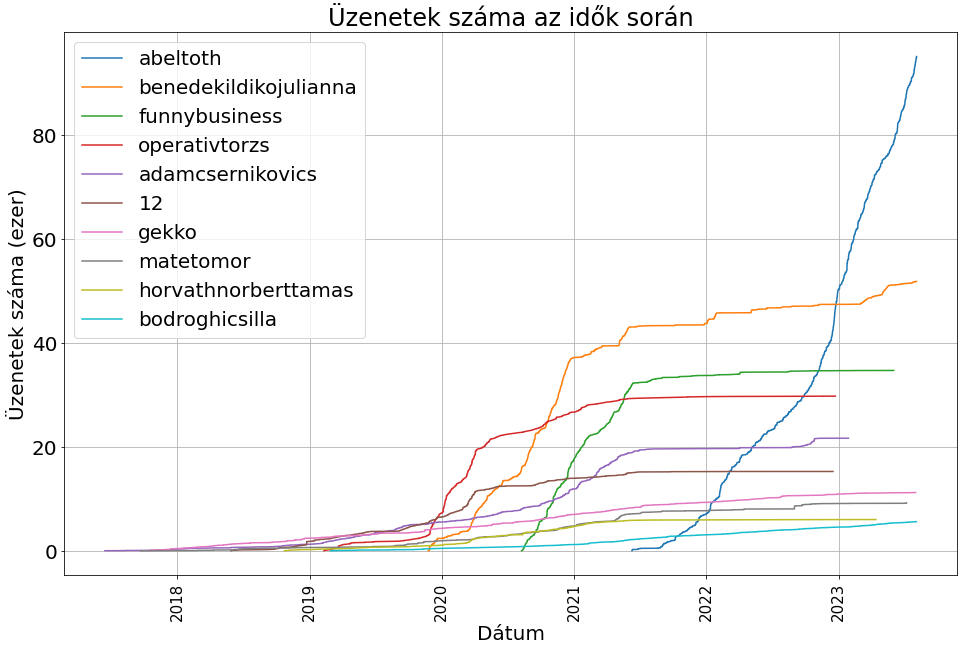

In [24]:
messages_time(sortedNames[0:10])


In [25]:
printFirsts(15)

1. abeltoth: 95210 üzenet
2. benedekildikojulianna: 51896 üzenet
3. funnybusiness: 34730 üzenet
4. operativtorzs: 29785 üzenet
5. adamcsernikovics: 21675 üzenet
6. 12: 15268 üzenet
7. gekko: 11212 üzenet
8. matetomor: 9205 üzenet
9. horvathnorberttamas: 6006 üzenet
10. bodroghicsilla: 5598 üzenet
11. benedekbartha: 4336 üzenet
12. specmatrakalovers: 4203 üzenet
13. afizikaszakkremje: 4178 üzenet
14. banyagep: 3931 üzenet
15. horvathaniko: 3680 üzenet


In [26]:
sortedNames.index("balazsbonifert")

164

Leírt karakterek
Balázs Bonifert :  866

Szavak száma
Balázs Bonifert :  36

Átlagos szóhossz
Balázs Bonifert :  24.1

Átlagos üzenethossz karakterben
Balázs Bonifert :  28.9


Találatok száma a(z) "kur" kifejezésre
Balázs Bonifert :  0


Balázs Bonifert válaszainak nan%-a 5 percen belül érkezik
Balázs Bonifert válaszainak nan%-a 1 percen belül érkezik



C:\Users\bonif\AppData\Local\Temp\ipykernel_18740\2793914684.py:3: RuntimeWarning: invalid value encountered in longlong_scalars
  portion=sum(counts)*100/len(respo)
C:\Users\bonif\AppData\Local\Temp\ipykernel_18740\2793914684.py:7: RuntimeWarning: invalid value encountered in longlong_scalars
  portion2=sum(counts2)*100/len(respo)
C:\Users\bonif\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


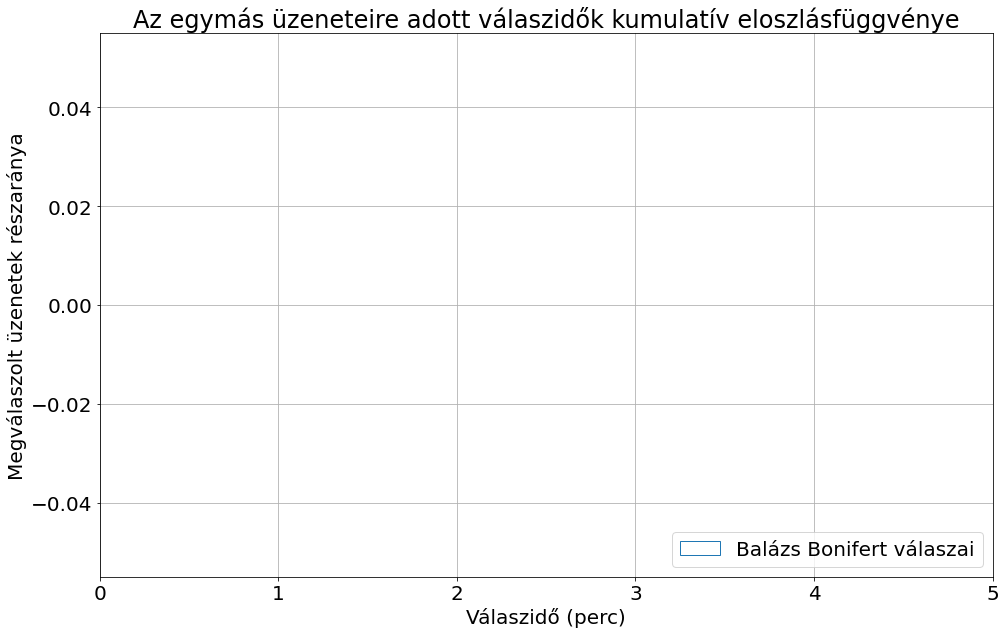

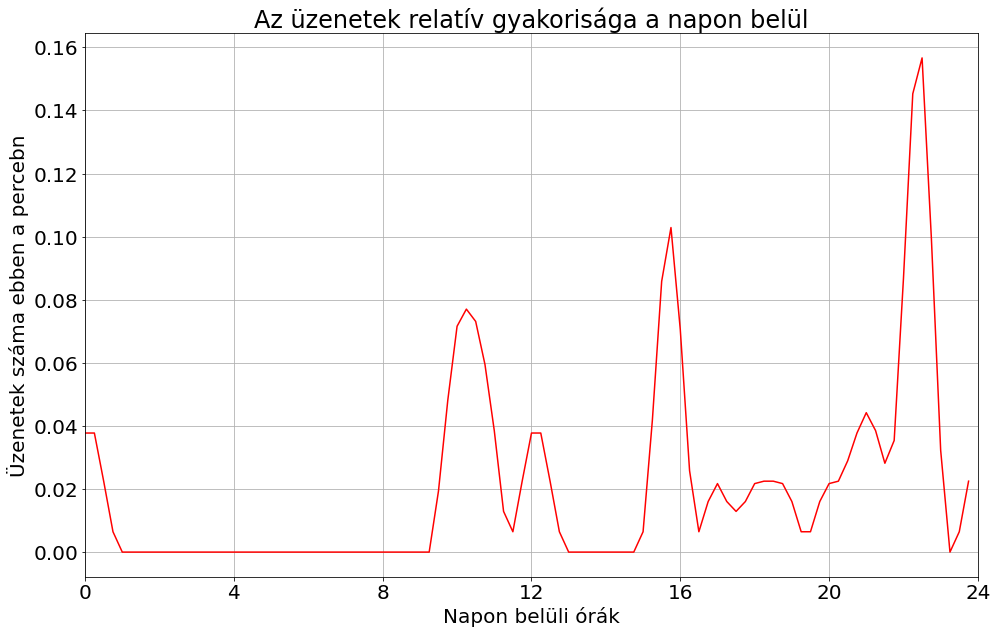

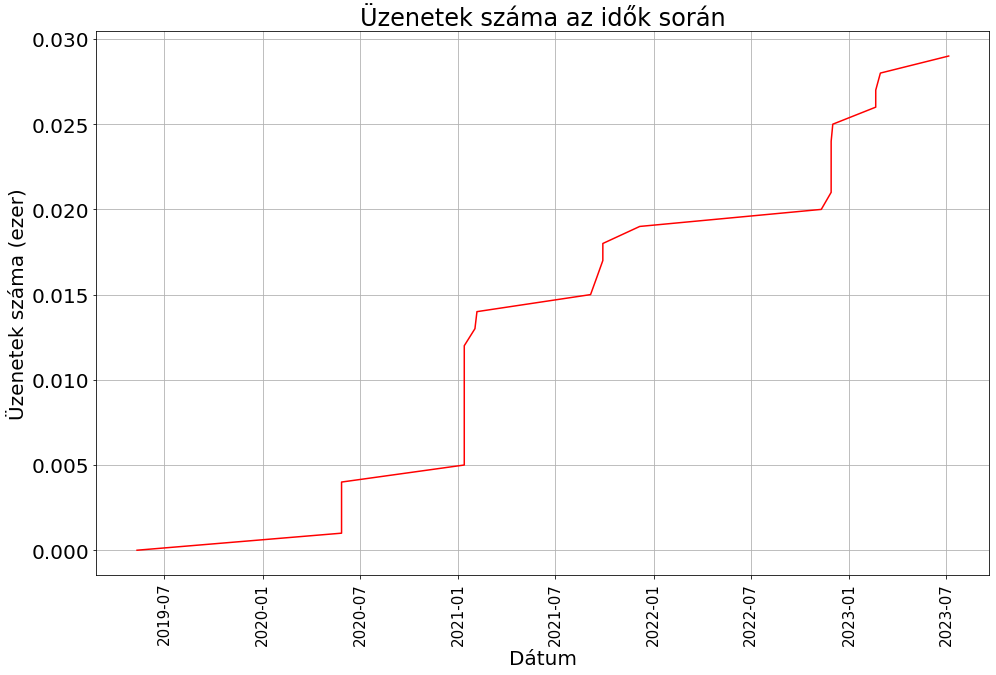

In [27]:
allInfo("balazsbonifert", szo="kur")

In [28]:
mm=mes["balazsbonifert"]
WordNumber(mm,"xd")
WordNumber(mm,"xdd")
WordNumber(mm,"xddd")
WordNumber(mm,"xdddd")
WordNumber(mm,"xddddd")

Találatok száma a(z) "xd" kifejezésre
Balázs Bonifert :  0


Találatok száma a(z) "xdd" kifejezésre
Balázs Bonifert :  0


Találatok száma a(z) "xddd" kifejezésre
Balázs Bonifert :  0


Találatok száma a(z) "xdddd" kifejezésre
Balázs Bonifert :  0


Találatok száma a(z) "xddddd" kifejezésre
Balázs Bonifert :  0


